### This analysis is based on the pull aligned continuous bhv variables and neural activity analysis
### The goal of this code is to define DHHM model and test the hypothesis that social gaze before pull serves as a evidence accumulation process, and test if the neural profile matches the accumulation hypothesis

In [1]:
import numpy as np
import pandas as pd # Added import for Pandas

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as st
import scipy.io
from scipy.stats import pearsonr

# import hddm
# import pymc as pm # Explicitly import pymc for summary function
# import arviz as az # Explicitly import arviz for summary function

# import pyddm
# from pyddm import gddm
# from pyddm import Sample

# from sklearn.neighbors import KernelDensity
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_samples, silhouette_score

# from dPCA import dPCA
import string
import warnings
import pickle
import json

from scipy.ndimage import gaussian_filter1d

import sys
import os
import glob
import random
from time import time


In [2]:
# to be able to use the functions in the ana_functions under /3d_recontruction_analysis_self_and_coop_task_neural_analysis/
sys.path.append(os.path.abspath('../3d_recontruction_analysis_self_and_coop_task_neural_analysis/'))

### function - get body part location for each pair of cameras

In [3]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [4]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [5]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [6]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody_2 import find_socialgaze_timepoint_singlecam_wholebody_2


### function - define time point of behavioral events

In [7]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [8]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.plot_continuous_bhv_var_singlecam import plot_continuous_bhv_var_singlecam
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [9]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [10]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_demo import tracking_video_singlecam_wholebody_withNeuron_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo import tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo
from ana_functions.tracking_frame_singlecam_wholebody_withNeuron_sepbhv_demo import tracking_frame_singlecam_wholebody_withNeuron_sepbhv_demo

### function - interval between all behavioral events

In [11]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - spike analysis

In [12]:
from ana_functions.spike_analysis_FR_calculation import spike_analysis_FR_calculation
from ana_functions.plot_spike_triggered_singlecam_bhvevent import plot_spike_triggered_singlecam_bhvevent
from ana_functions.plot_bhv_events_aligned_FR import plot_bhv_events_aligned_FR
from ana_functions.plot_strategy_aligned_FR import plot_strategy_aligned_FR

### function - PCA projection

In [13]:
from ana_functions.PCA_around_bhv_events import PCA_around_bhv_events
from ana_functions.PCA_around_bhv_events_video import PCA_around_bhv_events_video
from ana_functions.confidence_ellipse import confidence_ellipse

### function - HDDM related function

In [14]:
from functions._apply_gaussian_burst import _apply_gaussian_burst
from functions.generate_marmoset_pull_data import generate_marmoset_pull_data # create simulated data
from functions.compute_stats import compute_stats
from functions.align_and_plot_data import align_and_plot_data
from functions.get_aligned_segment import get_aligned_segment
from functions.analyze_pull_aligned_data import analyze_pull_aligned_data
from functions.analyze_pull_aligned_data_flexibleTW import analyze_pull_aligned_data_flexibleTW
from functions.analyze_pull_aligned_data_flexibleTW_newRTdefinition import analyze_pull_aligned_data_flexibleTW_newRTdefinition
from functions.analyze_pull_aligned_data_flexibleTW_newRTdefinition_2 import analyze_pull_aligned_data_flexibleTW_newRTdefinition_2

# from functions.run_hddm_modeling import run_hddm_modeling

### function - other useful functions

In [15]:
# for defining the meaningful social gaze (the continuous gaze distribution that is closest to the pull) 
from ana_functions.keep_closest_cluster_single_trial import keep_closest_cluster_single_trial

In [16]:
# get more information for each pull: number of preceding failed pull and time since last reward/successful pull
from ana_functions.get_pull_infos import get_pull_infos


## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [27]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# get the fs for neural recording
fs_spikes = 20000
fs_lfp = 1000

# frame number of the demo video
nframes = 0.5*30 # second*30fps
# nframes = 45*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# do OFC sessions or DLPFC sessions
do_OFC = 0
do_DLPFC  = 1
if do_OFC:
    savefile_sufix = '_OFCs'
elif do_DLPFC:
    savefile_sufix = '_DLPFCs'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used


# dodson ginger
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                    '20240531_Dodson_MC',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240604_Dodson_MC',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240607_Dodson_SR',
                                    '20240610_Dodson_MC',
                                    '20240611_Dodson_SR',
                                    '20240612_Dodson_MC',
                                    '20240613_Dodson_SR',
                                    '20240620_Dodson_SR',
                                    '20240719_Dodson_MC',
                                        
                                    '20250129_Dodson_MC',
                                    '20250130_Dodson_SR',
                                    '20250131_Dodson_MC',
                                
            
                                    '20250210_Dodson_SR_withKoala',
                                    '20250211_Dodson_MC_withKoala',
                                    '20250212_Dodson_SR_withKoala',
                                    '20250214_Dodson_MC_withKoala',
                                    '20250217_Dodson_SR_withKoala',
                                    '20250218_Dodson_MC_withKoala',
                                    '20250219_Dodson_SR_withKoala',
                                    '20250220_Dodson_MC_withKoala',
                                    '20250224_Dodson_KoalaAL_withKoala',
                                    '20250226_Dodson_MC_withKoala',
                                    '20250227_Dodson_KoalaAL_withKoala',
                                    '20250228_Dodson_DodsonAL_withKoala',
                                    '20250304_Dodson_DodsonAL_withKoala',
                                    '20250305_Dodson_MC_withKoala',
                                    '20250306_Dodson_KoalaAL_withKoala',
                                    '20250307_Dodson_DodsonAL_withKoala',
                                    '20250310_Dodson_MC_withKoala',
                                    '20250312_Dodson_NV_withKoala',
                                    '20250313_Dodson_NV_withKoala',
                                    '20250314_Dodson_NV_withKoala',
            
                                    '20250401_Dodson_MC_withKanga',
                                    '20250402_Dodson_MC_withKanga',
                                    '20250403_Dodson_MC_withKanga',
                                    '20250404_Dodson_SR_withKanga',
                                    '20250407_Dodson_SR_withKanga',
                                    '20250408_Dodson_SR_withKanga',
                                    '20250409_Dodson_MC_withKanga',
            
                                    '20250415_Dodson_MC_withKanga',
                                    # '20250416_Dodson_SR_withKanga', # has to remove from the later analysis, recording has problems
                                    '20250417_Dodson_MC_withKanga',
                                    '20250418_Dodson_SR_withKanga',
                                    '20250421_Dodson_SR_withKanga',
                                    '20250422_Dodson_MC_withKanga',
                                    '20250422_Dodson_SR_withKanga',
            
                                    '20250423_Dodson_MC_withKanga',
                                    '20250423_Dodson_SR_withKanga', 
                                    '20250424_Dodson_NV_withKanga',
                                    '20250424_Dodson_MC_withKanga',
                                    '20250424_Dodson_SR_withKanga',            
                                    '20250425_Dodson_NV_withKanga',
                                    '20250425_Dodson_SR_withKanga',
                                    '20250428_Dodson_NV_withKanga',
                                    '20250428_Dodson_MC_withKanga',
                                    '20250428_Dodson_SR_withKanga',  
                                    '20250429_Dodson_NV_withKanga',
                                    '20250429_Dodson_MC_withKanga',
                                    '20250429_Dodson_SR_withKanga',  
                                    '20250430_Dodson_NV_withKanga',
                                    '20250430_Dodson_MC_withKanga',
                                    '20250430_Dodson_SR_withKanga',  
            
                                   ]
        task_conditions = [
                            'MC',           
                            'MC',
                            'SR',
                            'MC',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            
                            'MC_withGingerNew',
                            'SR_withGingerNew',
                            'MC_withGingerNew',
            
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_withKoala',
                            'NV_withKoala',
                            'NV_withKoala',
                            'NV_withKoala',

                            'MC_withKanga',
                            'MC_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'MC_withKanga',
            
                            'MC_withKanga',
                            # 'SR_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
            
                            'MC_withKanga',
                            'SR_withKanga', 
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',            
                            'NV_withKanga',
                            'SR_withKanga',
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                          ]
        dates_list = [
                        '20240531',
                        '20240603_MC',
                        '20240603_SR',
                        '20240604',
                        '20240605_MC',
                        '20240605_SR',
                        '20240606_MC',
                        '20240606_SR',
                        '20240607',
                        '20240610_MC',
                        '20240611',
                        '20240612',
                        '20240613',
                        '20240620',
                        '20240719',
            
                        '20250129',
                        '20250130',
                        '20250131',
            
                        '20250210',
                        '20250211',
                        '20250212',
                        '20250214',
                        '20250217',
                        '20250218',
                        '20250219',
                        '20250220',
                        '20250224',
                        '20250226',
                        '20250227',
                        '20250228',
                        '20250304',
                        '20250305',
                        '20250306',
                        '20250307',
                        '20250310',
                        '20250312',
                        '20250313',
                        '20250314',
            
                        '20250401',
                        '20250402',
                        '20250403',
                        '20250404',
                        '20250407',
                        '20250408',
                        '20250409',
            
                        '20250415',
                        # '20250416',
                        '20250417',
                        '20250418',
                        '20250421',
                        '20250422',
                        '20250422_SR',
            
                        '20250423',
                        '20250423_SR', 
                        '20250424',
                        '20250424_MC',
                        '20250424_SR',            
                        '20250425',
                        '20250425_SR',
                        '20250428_NV',
                        '20250428_MC',
                        '20250428_SR',  
                        '20250429_NV',
                        '20250429_MC',
                        '20250429_SR',  
                        '20250430_NV',
                        '20250430_MC',
                        '20250430_SR',  
                     ]
        videodates_list = [
                            '20240531',
                            '20240603',
                            '20240603',
                            '20240604',
                            '20240605',
                            '20240605',
                            '20240606',
                            '20240606',
                            '20240607',
                            '20240610_MC',
                            '20240611',
                            '20240612',
                            '20240613',
                            '20240620',
                            '20240719',
            
                            '20250129',
                            '20250130',
                            '20250131',
                            
                            '20250210',
                            '20250211',
                            '20250212',
                            '20250214',
                            '20250217',
                            '20250218',          
                            '20250219',
                            '20250220',
                            '20250224',
                            '20250226',
                            '20250227',
                            '20250228',
                            '20250304',
                            '20250305',
                            '20250306',
                            '20250307',
                            '20250310',
                            '20250312',
                            '20250313',
                            '20250314',
            
                            '20250401',
                            '20250402',
                            '20250403',
                            '20250404',
                            '20250407',
                            '20250408',
                            '20250409',
            
                            '20250415',
                            # '20250416',
                            '20250417',
                            '20250418',
                            '20250421',
                            '20250422',
                            '20250422_SR',
            
                            '20250423',
                            '20250423_SR', 
                            '20250424',
                            '20250424_MC',
                            '20250424_SR',            
                            '20250425',
                            '20250425_SR',
                            '20250428_NV',
                            '20250428_MC',
                            '20250428_SR',  
                            '20250429_NV',
                            '20250429_MC',
                            '20250429_SR',  
                            '20250430_NV',
                            '20250430_MC',
                            '20250430_SR',  
            
                          ] # to deal with the sessions that MC and SR were in the same session
        session_start_times = [ 
                                0.00,
                                340,
                                340,
                                72.0,
                                60.1,
                                60.1,
                                82.2,
                                82.2,
                                35.8,
                                0.00,
                                29.2,
                                35.8,
                                62.5,
                                71.5,
                                54.4,
            
                                0.00,
                                0.00,
                                0.00,
            
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
            
                                0.00,
                                0.00,
                                73.5,
                                0.00,
                                76.1,
                                81.5,
                                0.00,
            
                                363,
                                # 0.00,
                                79.0,
                                162.6,
                                231.9,
                                109,
                                0.00,
            
                                0.00,
                                0.00, 
                                0.00,
                                0.00,
                                0.00,          
                                0.00,
                                93.0,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00, 
                                0.00,
                                274.4,
                                0.00,
            
                              ] # in second
        
        kilosortvers = list((np.ones(np.shape(dates_list))*4).astype(int))
        
        trig_channelnames = [ 'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0',# 'Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             
                              ]
        animal1_fixedorders = ['dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson',# 'dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson',
                              ]
        recordedanimals = animal1_fixedorders 
        animal2_fixedorders = ['ginger','ginger','ginger','ginger','ginger','ginger','ginger','ginger','ginger',
                               'ginger','ginger','ginger','ginger','ginger','ginger','gingerNew','gingerNew','gingerNew',
                               'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala',
                               'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala',
                               'koala', 'koala', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', # 'kanga', 
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                              ]

        animal1_filenames = ["Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             'Dodson',# 'Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson',
                            ]
        animal2_filenames = ["Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger",
                             "Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger",
                             "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala",
                             "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala",
                             "Koala", "Koala", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga",
                             'Kanga', # 'Kanga', 
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     '20231101_Dodson_withGinger_MC',
                                     '20231107_Dodson_withGinger_MC',
                                     '20231122_Dodson_withGinger_MC',
                                     '20231129_Dodson_withGinger_MC',
                                     '20231101_Dodson_withGinger_SR',
                                     '20231107_Dodson_withGinger_SR',
                                     '20231122_Dodson_withGinger_SR',
                                     '20231129_Dodson_withGinger_SR',
                                   ]
        task_conditions = [
                            'MC',
                            'MC',
                            'MC',
                            'MC',
                            'SR',
                            'SR',
                            'SR',
                            'SR',
                          ]
        dates_list = [
                      "20231101_MC",
                      "20231107_MC",
                      "20231122_MC",
                      "20231129_MC",
                      "20231101_SR",
                      "20231107_SR",
                      "20231122_SR",
                      "20231129_SR",      
                     ]
        videodates_list = dates_list
        session_start_times = [ 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                              ] # in second
        kilosortvers = [ 
                         2, 
                         2, 
                         4, 
                         4,
                         2, 
                         2, 
                         4, 
                         4,
                       ]
    
        trig_channelnames = ['Dev1/ai0']*np.shape(dates_list)[0]
        animal1_fixedorder = ['dodson']*np.shape(dates_list)[0]
        recordedanimals = animal1_fixedorders
        animal2_fixedorder = ['ginger']*np.shape(dates_list)[0]

        animal1_filename = ["Dodson"]*np.shape(dates_list)[0]
        animal2_filename = ["Ginger"]*np.shape(dates_list)[0]

    
# dannon kanga
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                     '20240508_Kanga_SR',
                                     '20240509_Kanga_MC',
                                     '20240513_Kanga_MC',
                                     '20240514_Kanga_SR',
                                     '20240523_Kanga_MC',
                                     '20240524_Kanga_SR',
                                     '20240606_Kanga_MC',
                                     '20240613_Kanga_MC_DannonAuto',
                                     '20240614_Kanga_MC_DannonAuto',
                                     '20240617_Kanga_MC_DannonAuto',
                                     '20240618_Kanga_MC_KangaAuto',
                                     '20240619_Kanga_MC_KangaAuto',
                                     '20240620_Kanga_MC_KangaAuto',
                                     '20240621_1_Kanga_NoVis',
                                     '20240624_Kanga_NoVis',
                                     '20240626_Kanga_NoVis',
            
                                     '20240808_Kanga_MC_withGinger',
                                     '20240809_Kanga_MC_withGinger',
                                     '20240812_Kanga_MC_withGinger',
                                     '20240813_Kanga_MC_withKoala',
                                     '20240814_Kanga_MC_withKoala',
                                     '20240815_Kanga_MC_withKoala',
                                     '20240819_Kanga_MC_withVermelho',
                                     '20240821_Kanga_MC_withVermelho',
                                     '20240822_Kanga_MC_withVermelho',
            
                                     '20250415_Kanga_MC_withDodson',
                                     '20250416_Kanga_SR_withDodson',
                                     '20250417_Kanga_MC_withDodson',
                                     '20250418_Kanga_SR_withDodson',
                                     '20250421_Kanga_SR_withDodson',
                                     '20250422_Kanga_MC_withDodson',
                                     '20250422_Kanga_SR_withDodson',
            
                                    '20250423_Kanga_MC_withDodson',
                                    '20250423_Kanga_SR_withDodson', 
                                    '20250424_Kanga_NV_withDodson',
                                    '20250424_Kanga_MC_withDodson',
                                    '20250424_Kanga_SR_withDodson',            
                                    '20250425_Kanga_NV_withDodson',
                                    '20250425_Kanga_SR_withDodson',
                                    '20250428_Kanga_NV_withDodson',
                                    '20250428_Kanga_MC_withDodson',
                                    '20250428_Kanga_SR_withDodson',  
                                    '20250429_Kanga_NV_withDodson',
                                    '20250429_Kanga_MC_withDodson',
                                    '20250429_Kanga_SR_withDodson',  
                                    '20250430_Kanga_NV_withDodson',
                                    '20250430_Kanga_MC_withDodson',
                                    '20250430_Kanga_SR_withDodson',  
                                   ]
        dates_list = [
                      "20240508",
                      "20240509",
                      "20240513",
                      "20240514",
                      "20240523",
                      "20240524",
                      "20240606",
                      "20240613",
                      "20240614",
                      "20240617",
                      "20240618",
                      "20240619",
                      "20240620",
                      "20240621_1",
                      "20240624",
                      "20240626",
            
                      "20240808",
                      "20240809",
                      "20240812",
                      "20240813",
                      "20240814",
                      "20240815",
                      "20240819",
                      "20240821",
                      "20240822",
            
                      "20250415",
                      "20250416",
                      "20250417",
                      "20250418",
                      "20250421",
                      "20250422",
                      "20250422_SR",
            
                        '20250423',
                        '20250423_SR', 
                        '20250424',
                        '20250424_MC',
                        '20250424_SR',            
                        '20250425',
                        '20250425_SR',
                        '20250428_NV',
                        '20250428_MC',
                        '20250428_SR',  
                        '20250429_NV',
                        '20250429_MC',
                        '20250429_SR',  
                        '20250430_NV',
                        '20250430_MC',
                        '20250430_SR',  
                     ]
        videodates_list = dates_list
        task_conditions = [
                             'SR',
                             'MC',
                             'MC',
                             'SR',
                             'MC',
                             'SR',
                             'MC',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'NV',
                             'NV',
                             'NV',   
                            
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withVermelho',
                             'MC_withVermelho',
                             'MC_withVermelho',
            
                             'MC_withDodson',
                             'SR_withDodson',
                             'MC_withDodson',
                             'SR_withDodson',
                             'SR_withDodson',
                             'MC_withDodson',
                             'SR_withDodson',
            
                             'MC_withDodson',
                            'SR_withDodson', 
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',            
                            'NV_withDodson',
                            'SR_withDodson',
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                          ]
        session_start_times = [ 
                                 0.00,
                                 36.0,
                                 69.5,
                                 0.00,
                                 62.0,
                                 0.00,
                                 89.0,
                                 0.00,
                                 0.00,
                                 0.00,
                                 165.8,
                                 96.0, 
                                 0.00,
                                 0.00,
                                 0.00,
                                 48.0,
                                
                                 59.2,
                                 49.5,
                                 40.0,
                                 50.0,
                                 0.00,
                                 69.8,
                                 85.0,
                                 212.9,
                                 68.5,
            
                                 363,
                                 0.00,
                                 79.0,
                                 162.6,
                                 231.9,
                                 109,
                                 0.00,
            
                                0.00,
                                0.00, 
                                0.00,
                                0.00,
                                0.00,          
                                0.00,
                                93.0,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00, 
                                0.00,
                                274.4,
                                0.00,
                              ] # in second
        kilosortvers = list((np.ones(np.shape(dates_list))*4).astype(int))
        
        trig_channelnames = ['Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                             'Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                              ]
        
        animal1_fixedorders = ['dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'ginger','ginger','ginger','koala','koala','koala','vermelho','vermelho',
                               'vermelho','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                              ]
        animal2_fixedorders = ['kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                              ]
        recordedanimals = animal2_fixedorders

        animal1_filenames = ["Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Ginger","Ginger","Ginger", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga",
                              "Kanga","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             
                            ]
        animal2_filenames = ["Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Koala","Koala","Koala","Vermelho","Vermelho",
                             "Vermelho","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     
                                   ]
        dates_list = [
                      
                     ]
        videodates_list = dates_list
        task_conditions = [
                           
                          ]
        session_start_times = [ 
                                
                              ] # in second
        kilosortvers = [ 

                       ]
    
        animal1_fixedorders = ['dannon']*np.shape(dates_list)[0]
        animal2_fixedorders = ['kanga']*np.shape(dates_list)[0]
        recordedanimals = animal2_fixedorders
        
        animal1_filenames = ["Dannon"]*np.shape(dates_list)[0]
        animal2_filenames = ["Kanga"]*np.shape(dates_list)[0]
    

    
# a test case
if 0: # kanga example
    neural_record_conditions = ['20250415_Kanga_MC_withDodson']
    dates_list = ["20250415"]
    videodates_list = dates_list
    task_conditions = ['MC_withDodson']
    session_start_times = [363] # in second
    kilosortvers = [4]
    trig_channelnames = ['Dev1/ai9']
    animal1_fixedorders = ['dodson']
    animal2_fixedorders = ['kanga']
    recordedanimals = animal2_fixedorders
    animal1_filenames = ["Dodson"]
    animal2_filenames = ["Kanga"]
if 0: # dodson example 
    neural_record_conditions = ['20250415_Dodson_MC_withKanga']
    dates_list = ["20250415"]
    videodates_list = dates_list
    task_conditions = ['MC_withKanga']
    session_start_times = [363] # in second
    kilosortvers = [4]
    trig_channelnames = ['Dev1/ai0']
    animal1_fixedorders = ['dodson']
    recordedanimals = animal1_fixedorders
    animal2_fixedorders = ['kanga']
    animal1_filenames = ["Dodson"]
    animal2_filenames = ["Kanga"]
    
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

# totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'

considerlevertube = 1
considertubeonly = 0

# location of levers and tubes for camera 2
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
# # location of the estimiated middle of the box
lever_locs_camI = {'dodson':np.array([1325,615]),'scorch':np.array([560,615])}
# # location of the estimated lever
# lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # old
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define hddm data summarizing data set    
hddm_datas_all_dates = dict.fromkeys(dates_list, [])
hddm_datas_flexibleTW_all_dates = dict.fromkeys(dates_list, [])
hddm_datas_flexibleTW_newRTdefinition_all_dates = dict.fromkeys(dates_list, [])


# where to save the summarizing data
data_saved_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'

# neural data folder
neural_data_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/Marmoset_neural_recording/'

    

In [28]:
print(np.shape(neural_record_conditions))
print(np.shape(task_conditions))
print(np.shape(dates_list))
print(np.shape(videodates_list)) 
print(np.shape(session_start_times))

print(np.shape(kilosortvers))

print(np.shape(trig_channelnames))
print(np.shape(animal1_fixedorders)) 
print(np.shape(recordedanimals))
print(np.shape(animal2_fixedorders))

print(np.shape(animal1_filenames))
print(np.shape(animal2_filenames))  

(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)


In [29]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
    dummy 
    
    #
    print('loading all data')
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
    
    with open(data_saved_subfolder+'/hddm_datas_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        hddm_datas_all_dates = pickle.load(f)
   
    with open(data_saved_subfolder+'/hddm_datas_flexibleTW_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        hddm_datas_flexibleTW_all_dates = pickle.load(f)        
        
    with open(data_saved_subfolder+'/hddm_datas_flexibleTW_newRTdefinition_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        hddm_datas_flexibleTW_newRTdefinition_all_dates = pickle.load(f)   
        
    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
    
        date_tgt = dates_list[idate]
        videodate_tgt = videodates_list[idate]
        
        neural_record_condition = neural_record_conditions[idate]
        
        session_start_time = session_start_times[idate]
        
        kilosortver = kilosortvers[idate]

        trig_channelname = trig_channelnames[idate]
        
        animal1_filename = animal1_filenames[idate]
        animal2_filename = animal2_filenames[idate]
        
        animal1_fixedorder = [animal1_fixedorders[idate]]
        animal2_fixedorder = [animal2_fixedorders[idate]]
        
        recordedanimal = recordedanimals[idate]
        
        # load behavioral results
        try:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            # 
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)   
        except:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            #
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
    
            
        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        # for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
        for itrial in trial_record['trial_number']:
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        # for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
        for itrial in np.arange(0,np.shape(trial_record_clean)[0],1):
            # ind = bhv_data["trial_number"]==itrial+1
            ind = bhv_data["trial_number"]==trial_record_clean['trial_number'][itrial]
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]

        
        
        # load behavioral event results
        try:
            # dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_key_locations.pkl', 'rb') as f:
                output_key_locations = pickle.load(f)
        except:   

            # folder and file path
            camera12_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
            camera23_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
            
            # 
            try: 
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
                bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
                if not os.path.exists(bodyparts_camI_camIJ):
                    singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                    bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
                if not os.path.exists(bodyparts_camI_camIJ):
                    singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                    bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"                
                # get the bodypart data from files
                bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
                video_file_original = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
            except:
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
                bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
                if not os.path.exists(bodyparts_camI_camIJ):
                    singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                    bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
                if not os.path.exists(bodyparts_camI_camIJ):
                    singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                    bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
            video_file_original = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
            
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            output_key_locations = find_socialgaze_timepoint_singlecam_wholebody_2(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,considerlevertube)
            
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_key_locations.pkl', 'wb') as f:
                pickle.dump(output_key_locations, f)
                

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        look_at_otherlever_or_not_merge = output_look_ornot['look_at_otherlever_or_not_merge']
        look_at_otherface_or_not_merge = output_look_ornot['look_at_otherface_or_not_merge']
        
        # change the unit to second and align to the start of the session
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 
        look_at_otherlever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherlever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_otherface_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherface_or_not_merge['dodson'])[0],1)/fps - session_start_time

        
        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
        lever_gaze1 = output_time_points_levertube['time_point_lookatlever1']
        lever_gaze2 = output_time_points_levertube['time_point_lookatlever2']
        # 
        # mostly just for the sessions in which MC and SR are in the same session 
        firstpulltime = np.nanmin([np.nanmin(time_point_pull1),np.nanmin(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1>(firstpulltime-15)] # 15s before the first pull (animal1 or 2) count as the active period
        oneway_gaze2 = oneway_gaze2[oneway_gaze2>(firstpulltime-15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1>(firstpulltime-15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2>(firstpulltime-15)]  
        lever_gaze1 = lever_gaze1[lever_gaze1>(firstpulltime-15)]
        lever_gaze2 = lever_gaze2[lever_gaze2>(firstpulltime-15)]
        #    
        # newly added condition: only consider gaze during the active pulling time (15s after the last pull)    
        lastpulltime = np.nanmax([np.nanmax(time_point_pull1),np.nanmax(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1<(lastpulltime+15)]    
        oneway_gaze2 = oneway_gaze2[oneway_gaze2<(lastpulltime+15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1<(lastpulltime+15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2<(lastpulltime+15)] 
        lever_gaze1 = lever_gaze1[lever_gaze1<(lastpulltime+15)] 
        lever_gaze2 = lever_gaze2[lever_gaze2<(lastpulltime+15)] 
            
        # define successful pulls and failed pulls
        # a new definition of successful and failed pulls
        # separate successful and failed pulls
        # step 1 all pull and juice
        time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
        time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
        time_point_juice1 = bhv_data["time_points"][bhv_data["behavior_events"]==3]
        time_point_juice2 = bhv_data["time_points"][bhv_data["behavior_events"]==4]
        # step 2:
        # pull 1
        # Find the last pull before each juice
        successful_pull1 = [time_point_pull1[time_point_pull1 < juice].max() for juice in time_point_juice1]
        # Convert to Pandas Series
        successful_pull1 = pd.Series(successful_pull1, index=time_point_juice1.index)
        # Find failed pulls (pulls that are not successful)
        failed_pull1 = time_point_pull1[~time_point_pull1.isin(successful_pull1)]
        # pull 2
        # Find the last pull before each juice
        successful_pull2 = [time_point_pull2[time_point_pull2 < juice].max() for juice in time_point_juice2]
        # Convert to Pandas Series
        successful_pull2 = pd.Series(successful_pull2, index=time_point_juice2.index)
        # Find failed pulls (pulls that are not successful)
        failed_pull2 = time_point_pull2[~time_point_pull2.isin(successful_pull2)]
        #
        # step 3:
        time_point_pull1_succ = np.round(successful_pull1,1)
        time_point_pull2_succ = np.round(successful_pull2,1)
        time_point_pull1_fail = np.round(failed_pull1,1)
        time_point_pull2_fail = np.round(failed_pull2,1)
        # 
        time_point_pulls_succfail = { "pull1_succ":time_point_pull1_succ,
                                      "pull2_succ":time_point_pull2_succ,
                                      "pull1_fail":time_point_pull1_fail,
                                      "pull2_fail":time_point_pull2_fail,
                                    }
        
        # 
        # based on time point pull and juice, define some features for each pull action
        pull_infos = get_pull_infos(animal1, animal2, time_point_pull1, time_point_pull2, 
                                    time_point_juice1, time_point_juice2)
        
        # new total session time (instead of 600s) - total time of the video recording
        totalsess_time = np.ceil(np.shape(output_look_ornot['look_at_lever_or_not_merge']['dodson'])[0]/30) 
        
        #
        # organize variables that are required by the HDDM functions
        # load the data first, if not process and then save the data 
        print('prepare the data for HDDM')
        try:
            dummy
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_hddm_model/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            with open(add_date_dir+'/hddm_data.pkl', 'rb') as f:
                hddm_data = pickle.load(f)
            with open(add_date_dir+'/hddm_data_flexibleTW.pkl', 'rb') as f:
                hddm_data_flexibleTW = pickle.load(f)
            with open(add_date_dir+'/hddm_data_flexibleTW_newRT.pkl', 'rb') as f:
                hddm_data_flexibleTW_newRT = pickle.load(f)
        except:
            print('no HDDM data, analyze it and save it')
            #
            gausKernelsize = 4
            #
            # clean the data
            time_point_pull1 = np.array(time_point_pull1)+session_start_time
            time_point_pull1 = time_point_pull1[time_point_pull1<totalsess_time]
            time_point_pull2 = np.array(time_point_pull2)+session_start_time
            time_point_pull2 = time_point_pull2[time_point_pull2<totalsess_time]
            #
            time_point_juice1 = np.array(time_point_juice1)+session_start_time
            time_point_juice1 = time_point_juice1[time_point_juice1<totalsess_time]
            time_point_juice2 = np.array(time_point_juice2)+session_start_time
            time_point_juice2 = time_point_juice2[time_point_juice2<totalsess_time]
            #
            oneway_gaze1 = np.sort(np.hstack((oneway_gaze1,mutual_gaze1)))
            animal1_gaze = oneway_gaze1
            animal1_gaze = np.sort(np.unique(animal1_gaze))+session_start_time
            #
            oneway_gaze2 = np.sort(np.hstack((oneway_gaze2,mutual_gaze2)))
            animal2_gaze = oneway_gaze2
            animal2_gaze = np.sort(np.unique(animal2_gaze))+session_start_time
            #
            lever_gaze1 = np.array(lever_gaze1)+session_start_time
            lever_gaze1 = lever_gaze1[lever_gaze1<totalsess_time]
            lever_gaze2 = np.array(lever_gaze2)+session_start_time
            lever_gaze2 = lever_gaze2[lever_gaze2<totalsess_time]
            
            #
            # organize the data into a time series
            pull1_data = np.zeros([int(totalsess_time*fps),])
            pull1_data[np.round(time_point_pull1*fps).astype(int)]=1
            #
            pull2_data = np.zeros([int(totalsess_time*fps),])
            pull2_data[np.round(time_point_pull2*fps).astype(int)]=1
            #
            juice1_data = np.zeros([int(totalsess_time*fps),])
            juice1_data[np.round(time_point_juice1*fps).astype(int)]=1
            #
            juice2_data = np.zeros([int(totalsess_time*fps),])
            juice2_data[np.round(time_point_juice2*fps).astype(int)]=1
            #
            levergaze1_data = np.zeros([int(totalsess_time*fps),])
            # levergaze1_data[np.round(lever_gaze1*fps).astype(int)]=1
            levergaze1_data = scipy.ndimage.gaussian_filter1d(levergaze1_data,gausKernelsize)
            #
            levergaze2_data = np.zeros([int(totalsess_time*fps),])
            # levergaze2_data[np.round(lever_gaze2*fps).astype(int)]=1
            levergaze2_data = scipy.ndimage.gaussian_filter1d(levergaze2_data,gausKernelsize)
            #
            gaze1_data = np.zeros([int(totalsess_time*fps),])
            gaze1_data[np.round(animal1_gaze*fps).astype(int)]=1
            gaze1_data = scipy.ndimage.gaussian_filter1d(gaze1_data,gausKernelsize)
            #
            gaze2_data = np.zeros([int(totalsess_time*fps),])
            gaze2_data[np.round(animal2_gaze*fps).astype(int)]=1
            gaze2_data = scipy.ndimage.gaussian_filter1d(gaze2_data,gausKernelsize)
            #
            facemass1 = output_key_locations['facemass_loc_all_merge']['dodson'].transpose()
            facemass1 = np.hstack((facemass1,[[np.nan],[np.nan]]))
            at1_min_at0 = (facemass1[:,1:]-facemass1[:,:-1])
            speed1_data = np.sqrt(np.einsum('ij,ij->j', at1_min_at0, at1_min_at0))*fps 
            speed1_data = scipy.ndimage.gaussian_filter1d(speed1_data,gausKernelsize*5)
            #
            facemass2 = output_key_locations['facemass_loc_all_merge']['scorch'].transpose()
            facemass2 = np.hstack((facemass2,[[np.nan],[np.nan]]))
            at1_min_at0 = (facemass2[:,1:]-facemass2[:,:-1])
            speed2_data = np.sqrt(np.einsum('ij,ij->j', at1_min_at0, at1_min_at0))*fps 
            speed2_data = scipy.ndimage.gaussian_filter1d(speed2_data,gausKernelsize*5)
            #
            gazevect1 = np.array(output_allvectors['head_vect_all_merge']['dodson']).transpose()
            gazevect1 = np.hstack((gazevect1, [[np.nan], [np.nan]]))
            at1 = gazevect1[:, 1:]
            at0 = gazevect1[:, :-1] 
            nframes = np.shape(at1)[1]
            anglespeed1_data = np.full(nframes, np.nan)
            #
            eps = 1e-10
            for iframe in np.arange(0, nframes, 1):
                norm1 = np.linalg.norm(at1[:, iframe]) + eps
                norm0 = np.linalg.norm(at0[:, iframe]) + eps
                dot_val = np.dot(at1[:, iframe]/norm1, at0[:, iframe]/norm0)
                anglespeed1_data[iframe] = np.arccos(np.clip(dot_val, -1.0, 1.0))    
            #
            # fill NaNs
            nans = np.isnan(anglespeed1_data)
            if np.any(~nans):
                anglespeed1_data[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), anglespeed1_data[~nans])
            anglespeed1_data = scipy.ndimage.gaussian_filter1d(anglespeed1_data, gausKernelsize*5)
            #
            gazevect2 = np.array(output_allvectors['head_vect_all_merge']['scorch']).transpose()
            gazevect2 = np.hstack((gazevect2, [[np.nan], [np.nan]]))
            at1 = gazevect2[:, 1:]
            at0 = gazevect2[:, :-1] 
            nframes = np.shape(at1)[1]
            anglespeed2_data = np.full(nframes, np.nan)
            #
            for iframe in np.arange(0, nframes, 1):
                norm1 = np.linalg.norm(at1[:, iframe]) + eps
                norm0 = np.linalg.norm(at0[:, iframe]) + eps
                dot_val = np.dot(at1[:, iframe]/norm1, at0[:, iframe]/norm0)
                anglespeed2_data[iframe] = np.arccos(np.clip(dot_val, -1.0, 1.0))    
            #
            # fill NaNs
            nans = np.isnan(anglespeed2_data)
            if np.any(~nans):
                anglespeed2_data[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), anglespeed2_data[~nans])
            anglespeed2_data = scipy.ndimage.gaussian_filter1d(anglespeed2_data, gausKernelsize*5)
                 
            #
            # get the data that can be used for the HDDM pipeline
            # also plot the correlation 
            time_window_start_s=-4 # same setting as in the other analysis pipeline
            time_window_end_s=0
            coop_window = 1
            resolution = 1/fps
            #
            if np.isin(animal1,animal1_fixedorder):
                hddm_data = analyze_pull_aligned_data(pull1_data, pull2_data, gaze1_data, gaze2_data, 
                                                     speed1_data, speed2_data, resolution, time_window_start_s, 
                                                     time_window_end_s, coop_window)

                hddm_data_flexibleTW = analyze_pull_aligned_data_flexibleTW(pull1_data, pull2_data, 
                                                                           gaze1_data, gaze2_data, 
                                                                           speed1_data, speed2_data, resolution, 
                                                                           time_window_start_s, time_window_end_s, 
                                                                           coop_window)
                
                hddm_data_flexibleTW_newRT = analyze_pull_aligned_data_flexibleTW_newRTdefinition_2(pull1_data, pull2_data, 
                                                                           juice1_data, juice2_data,
                                                                           gaze1_data, gaze2_data, 
                                                                           levergaze1_data, levergaze2_data, 
                                                                           speed1_data, speed2_data, 
                                                                           anglespeed1_data, anglespeed2_data, 
                                                                           resolution, 
                                                                           session_start_time, fps
                                                                           )
            else:
                hddm_data = analyze_pull_aligned_data(pull2_data, pull1_data, gaze2_data, gaze1_data, 
                                                     speed2_data, speed1_data, resolution, time_window_start_s, 
                                                     time_window_end_s, coop_window)

                hddm_data_flexibleTW = analyze_pull_aligned_data_flexibleTW(pull2_data, pull1_data, 
                                                                           gaze2_data, gaze1_data, 
                                                                           speed2_data, speed1_data, resolution, 
                                                                           time_window_start_s, time_window_end_s, 
                                                                           coop_window)
                
                hddm_data_flexibleTW_newRT = analyze_pull_aligned_data_flexibleTW_newRTdefinition_2(pull2_data, pull1_data, 
                                                                           juice2_data, juice1_data,
                                                                           gaze2_data, gaze1_data, 
                                                                           levergaze2_data, levergaze1_data, 
                                                                           speed2_data, speed1_data,
                                                                           anglespeed2_data, anglespeed1_data,                      
                                                                           resolution, 
                                                                           session_start_time, fps
                                                                           )
            
            #
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_hddm_model/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(add_date_dir+'/hddm_data.pkl', 'wb') as f:
                pickle.dump(hddm_data, f)
            with open(add_date_dir+'/hddm_data_flexibleTW.pkl', 'wb') as f:
                pickle.dump(hddm_data_flexibleTW, f)
            with open(add_date_dir+'/hddm_data_flexibleTW_newRT.pkl', 'wb') as f:
                pickle.dump(hddm_data_flexibleTW_newRT, f)
      
        #    
        hddm_datas_all_dates[date_tgt] = hddm_data
        hddm_datas_flexibleTW_all_dates[date_tgt] = hddm_data_flexibleTW
        hddm_datas_flexibleTW_newRTdefinition_all_dates[date_tgt] = hddm_data_flexibleTW_newRT
        
        
            
        # # #     
        # load and organize neural related data   
        # # # 
            
        # session starting time compared with the neural recording
        session_start_time_niboard_offset = ni_data['session_t0_offset'] # in the unit of second
        try:
            neural_start_time_niboard_offset = ni_data['trigger_ts'][0]['elapsed_time'] # in the unit of second
        except: # for the multi-animal recording setup
            neural_start_time_niboard_offset = next(
                entry['timepoints'][0]['elapsed_time']
                for entry in ni_data['trigger_ts']
                if entry['channel_name'] == f"{trig_channelname}")
        neural_start_time_session_start_offset = neural_start_time_niboard_offset-session_start_time_niboard_offset
    
    
        # load channel maps
        channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32.mat'
        # channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32_kilosort4_new.mat'
        channel_map_data = scipy.io.loadmat(channel_map_file)     
        
        # 
        # # load spike sorting results
        if 0:
            print('load spike data for '+neural_record_condition)
            if kilosortver == 2:
                spike_time_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            elif kilosortver == 4:
                spike_time_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            # 
            # align the FR recording time stamps
            spike_time_data = spike_time_data + fs_spikes*neural_start_time_session_start_offset
            # down-sample the spike recording resolution to 30Hz
            spike_time_data = spike_time_data/fs_spikes*fps
            # spike_time_data = np.round(spike_time_data)
            #
            if kilosortver == 2:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            elif kilosortver == 4:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            #
            if kilosortver == 2:
                channel_maps_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            elif kilosortver == 4:
                channel_maps_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            #
            if kilosortver == 2:
                channel_pos_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            elif kilosortver == 4:
                channel_pos_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            #
            if kilosortver == 2:
                clusters_info_file = neural_data_folder+neural_record_condition+'/Kilosort/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            elif kilosortver == 4:
                clusters_info_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            #
            # only get the spikes that are manually checked
            try:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['cluster_id'].values
            except:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['id'].values
            #
            clusters_info_data = clusters_info_data[~pd.isnull(clusters_info_data.group)]
            #
            spike_time_data = spike_time_data[np.isin(spike_clusters_data,good_clusters)]
            spike_channels_data = spike_channels_data[np.isin(spike_clusters_data,good_clusters)]
            spike_clusters_data = spike_clusters_data[np.isin(spike_clusters_data,good_clusters)]
            
            #
            nclusters = np.shape(clusters_info_data)[0]
            #
            for icluster in np.arange(0,nclusters,1):
                try:
                    cluster_id = clusters_info_data['id'].iloc[icluster]
                except:
                    cluster_id = clusters_info_data['cluster_id'].iloc[icluster]
                spike_channels_data[np.isin(spike_clusters_data,cluster_id)] = clusters_info_data['ch'].iloc[icluster]   
            # 
            # get the channel to depth information, change 2 shanks to 1 shank 
            try:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1]*2,channel_pos_data[channel_pos_data[:,0]==1,1]*2+1])
                # channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
            except:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
                channel_to_depth[1] = channel_to_depth[1]/30-64 # make the y axis consistent
            #
           
            
            # calculate the firing rate
            # FR_kernel = 0.20 # in the unit of second
            FR_kernel = 1/30 # in the unit of second # 1/30 same resolution as the video recording
            # FR_kernel is sent to to be this if want to explore it's relationship with continuous trackng data
            
            totalsess_time_forFR = np.floor(np.shape(output_look_ornot['look_at_lever_or_not_merge']['dodson'])[0]/30)  # to match the total time of the video recording
            #
            _,FR_timepoint_allch,FR_allch,FR_zscore_allch = spike_analysis_FR_calculation(fps, FR_kernel, totalsess_time_forFR,
                                                                                          spike_clusters_data, spike_time_data)
            # _,FR_timepoint_allch,FR_allch,FR_zscore_allch = spike_analysis_FR_calculation(fps,FR_kernel,totalsess_time_forFR,
            #                                                                              spike_channels_data, spike_time_data)                     
            
            #
            # Run PCA analysis
            FR_zscore_allch_np_merged = np.array(pd.DataFrame(FR_zscore_allch).T)
            FR_zscore_allch_np_merged = FR_zscore_allch_np_merged[~np.isnan(np.sum(FR_zscore_allch_np_merged,axis=1)),:]
            # # run PCA on the entire session
            pca = PCA(n_components=3)
            FR_zscore_allch_PCs = pca.fit_transform(FR_zscore_allch_np_merged.T)
           
            
 

    # save data
    if 1:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)

        with open(data_saved_subfolder+'/hddm_datas_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(hddm_datas_all_dates, f) 
        with open(data_saved_subfolder+'/hddm_datas_flexibleTW_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(hddm_datas_flexibleTW_all_dates, f) 
        with open(data_saved_subfolder+'/hddm_datas_flexibleTW_newRTdefinition_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(hddm_datas_flexibleTW_newRTdefinition_all_dates, f) 
            
    
    # only save a subset 
    if 0:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)

        with open(data_saved_subfolder+'/hddm_datas_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(hddm_datas_all_dates, f) 
        with open(data_saved_subfolder+'/hddm_datas_flexibleTW_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(hddm_datas_flexibleTW_all_dates, f) 
        with open(data_saved_subfolder+'/hddm_datas_flexibleTW_newRTdefinition_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(hddm_datas_flexibleTW_newRTdefinition_all_dates, f) 
     
   
    

analyze all dates
load social gaze with camera-2 only of 20240508
prepare the data for HDDM
no HDDM data, analyze it and save it
load social gaze with camera-2 only of 20240509
prepare the data for HDDM
no HDDM data, analyze it and save it
load social gaze with camera-2 only of 20240513
prepare the data for HDDM
no HDDM data, analyze it and save it
load social gaze with camera-2 only of 20240514
prepare the data for HDDM
no HDDM data, analyze it and save it
load social gaze with camera-2 only of 20240523
prepare the data for HDDM
no HDDM data, analyze it and save it
load social gaze with camera-2 only of 20240524
prepare the data for HDDM
no HDDM data, analyze it and save it
load social gaze with camera-2 only of 20240606
prepare the data for HDDM
no HDDM data, analyze it and save it
load social gaze with camera-2 only of 20240613
prepare the data for HDDM
no HDDM data, analyze it and save it
load social gaze with camera-2 only of 20240614
prepare the data for HDDM
no HDDM data, analyz

### fit the HDDM model for all the data, copy this part and following to the Misha later when HDDM pipeline is installed successfully
### try the pyddm pipeline but does not work well, so the code is old

In [30]:
# 
animal_tgt = 'kanga' # 'kanga','kanga_partner','dodson','dodson_partner'
# animal_tgt = 'dodson'

#
# conditions_to_ana = np.unique(task_conditions)
###
# For Kanga
# conditions_to_ana = [ 'MC_withVermelho']
conditions_to_ana = ['MC', 'MC_withDodson','MC_withGinger', 'MC_withKoala', 'MC_withVermelho', ] # all MC
# conditions_to_ana = ['SR', 'SR_withDodson', ] # all SR
# conditions_to_ana = ['MC', 'MC_withDodson', 'MC_withVermelho', ] # MC with male
# conditions_to_ana = ['MC_withGinger', 'MC_withKoala', ] # MC with female
# conditions_to_ana = ['MC', ] # MC with familiar male
# conditions_to_ana = ['MC_withGinger', ] # MC with familiar female
# conditions_to_ana = ['MC_withDodson', 'MC_withVermelho', ] # MC with unfamiliar male
# conditions_to_ana = ['MC_withKoala', ] # MC with unfamiliar female
# conditions_to_ana = ['MC_DannonAuto'] # partner AL
# conditions_to_ana = ['MC_KangaAuto'] # self AL
# conditions_to_ana = ['NV','NV_withDodson'] # NV
# conditions_to_ana = ['MC', 'MC_withDodson','MC_withGinger', 'MC_withKoala', 'MC_withVermelho', 
#                      'SR', 'SR_withDodson',]
###
# For Dodson
# conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', ] # all MC
# conditions_to_ana = ['MC', 'MC_withKanga', ] # all MC
# conditions_to_ana = ['SR', 'SR_withGingerNew', 'SR_withKanga', 'SR_withKoala', ] # all SR
# conditions_to_ana = ['MC', 'MC_withKanga', 'MC_withKoala', ] # all MC, no gingerNew
# conditions_to_ana = ['SR', 'SR_withKanga', 'SR_withKoala', ] # all SR,  no gingerNew
# conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', ] # MC with female
# conditions_to_ana = ['MC', 'MC_withGingerNew', ] # MC with familiar female
# conditions_to_ana = ['MC_withKanga', 'MC_withKoala', ] # MC with unfamiliar female
# conditions_to_ana = ['MC_KoalaAuto_withKoala'] # partner AL
# conditions_to_ana = ['MC_DodsonAuto_withKoala'] # self AL
# conditions_to_ana = ['NV_withKanga'] # NV
# conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', 
#                      'SR', 'SR_withGingerNew', 'SR_withKanga', 'SR_withKoala', ]


# cond_toplot_type = 'allSR'
cond_toplot_type = 'allMC'
# cond_toplot_type =  'MC_withVermelho'

# make sure to only look certain condition, and keep things consistent
ind_tgt = list(np.isin(task_conditions,conditions_to_ana))

animal1_fixedorders_toana = list(np.array(animal1_fixedorders)[ind_tgt])
animal2_fixedorders_toana = list(np.array(animal2_fixedorders)[ind_tgt])
task_conditions_toana = list(np.array(task_conditions)[ind_tgt])

dates_to_ana = list(np.array(dates_list)[ind_tgt])
ndates_to_ana = np.shape(dates_to_ana)[0]

In [31]:
# combine the target sessions together, then run the pyddm fitting

if 1:

    dofixTW = 0 # 0: not do the fixed TW, instead use the flexible TW (from one pull to another); 1: do the fixed tw (-4s to 0s)
    doflexTW_newRT = 1 # 1: do the flexible TW with new definition of RT
    #
    if dofixTW:
        fixTW_sufix = '_fixedTW'
    elif not dofixTW:
        if not doflexTW_newRT:
            fixTW_sufix = ''
        elif doflexTW_newRT:
            fixTW_sufix = '_flexTW_newRT'
        
    # only run the noselfgaze hddm fitting
    doNogazeOnly = 1
    
    # use more variables for v a and z
    doExaustModel = 0
    if doExaustModel:
        exaustModel_sufix = '_exaustModel'
    elif not doExaustModel:
        exaustModel_sufix = ''
        
        
    # try to load the data first
    try:
        d
        current_dir = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal_tgt
        add_date_dir = os.path.join(current_dir+'/hddm_model_fitted_combinedsession')
        #
        if not doNogazeOnly:
            with open(add_date_dir+'/hddm_model_fitted_traces_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'rb') as f:
                hddm_model_fitted_traces = pickle.load(f)
            
            with open(add_date_dir+'/hddm_model_fitted_stats_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'rb') as f:
                hddm_model_fitted_stats = pickle.load(f)
            
            with open(add_date_dir+'/hddm_model_fitted_dic_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'rb') as f:
                hddm_model_fitted_dic = pickle.load(f)
        #
        with open(add_date_dir+'/hddm_model_fitted_nogaze_traces_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'rb') as f:
            hddm_model_fitted_nogaze_traces = pickle.load(f)
        
        with open(add_date_dir+'/hddm_model_fitted_nogaze_stats_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'rb') as f:
            hddm_model_fitted_nogaze_stats = pickle.load(f)
        
        with open(add_date_dir+'/hddm_model_fitted_nogaze_dic_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'rb') as f:
            hddm_model_fitted_nogaze_dic = pickle.load(f)
            
        with open(add_date_dir+'/hddm_data_tgt_alldates_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'rb') as f:
            hddm_data_tgt_alldates = pickle.load(f)

        print(animal_tgt+' '+cond_toplot_type+' hddm fitting results loaded')

    # do the hddm model fitting    
    except:
        print(animal_tgt+' '+cond_toplot_type+' running hddm fitting')
        
        for idate in np.arange(0,ndates_to_ana,1):
        # for idate in np.arange(3,4,1):

            date_toana = dates_to_ana[idate]
            
            task_condition_toana = task_conditions_toana[idate]

            animal1_fixedorder = [animal1_fixedorders_toana[idate]]
            animal2_fixedorder = [animal2_fixedorders_toana[idate]]
    

            if np.isin(animal_tgt,animal1_fixedorders[idate]):
                animal_id_toana = 'animal1'
            elif np.isin(animal_tgt,animal2_fixedorders[idate]):
                animal_id_toana = 'animal2'

            # # use the fixed -4s to 0s time window
            if dofixTW:
                hddm_data = hddm_datas_all_dates[date_toana]
            # us the flexible time window setting
            else:
                if not doflexTW_newRT:
                    hddm_data = hddm_datas_flexibleTW_all_dates[date_toana]
                # use the new RT definition
                else:
                    hddm_data = hddm_datas_flexibleTW_newRTdefinition_all_dates[date_toana]

            hddm_data_tgt_idate = hddm_data['hddm_data_'+animal_id_toana]
            
            # add a date column and task condition column
            hddm_data_tgt_idate['date'] = date_toana
            hddm_data_tgt_idate['condition'] = task_condition_toana       
            
            #
            if idate == 0:
                hddm_data_tgt_alldates = hddm_data_tgt_idate
            else:
                hddm_data_tgt_alldates = pd.concat([hddm_data_tgt_alldates, hddm_data_tgt_idate])
              
            
        # add an semi-artl cretiera
        # hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['rt']>5]
            


        df_animal_data = hddm_data_tgt_alldates.copy()

        if 0:
            # ind_ = df_animal_data['date'] == np.unique(df_animal_data['date'])[0]
            # df_animal_data = df_animal_data[ind_]
            
            ind_ = df_animal_data['rt']>5
            df_animal_data = df_animal_data[ind_]
            
            # df_animal_data = df_animal_data[0:10]
            print(df_animal_data)
    
    
            samples = Sample.from_pandas_dataframe(df_animal_data,rt_column_name='rt',choice_column_name='response')
    
    
            m = pyddm.gddm(drift=lambda ds, partner_mean_speed, d: d+ds*partner_mean_speed,
                   # drift= 'd', 
                    noise=1,
                   bound="b",
                   nondecision="ndtime",
                   starting_position= 'x0',
                   parameters={"d": (-20,20), "b": (0.4, 10), "ndtime": (0, 5), "ds":(-0.1,0.1),'x0':(0,1)},
                   conditions=["partner_mean_speed"],
                   T_dur = 16,
                   dt = 0.01,
                   dx = 0.01,
                  )
    
            m.fit(sample=samples, lossfunction=pyddm.models.loss.LossRobustBIC, verbose=False) # Set verbose=True to see fitting progress
            m.show()
            print("Parameters:", m.parameters())
    
            import pyddm.plot
            pyddm.plot.plot_fit_diagnostics(model=m, sample=samples)

kanga allMC running hddm fitting


In [32]:
df_animal_data

,subj_idx,rt,response,self_gaze_auc,partner_mean_speed,self_mean_speed,failed_pulls_before_reward,time_since_last_reward,current_pull_time,previous_pull_time,current_trial_start_time,prev_trial_outcome,date,condition
1,animal2,2.833333,1,0.166667,209.877724,297.526719,1,27.933333,27.933333,23.266667,25.100000,0,20240509,MC
2,animal2,3.033333,1,0.033333,81.742966,208.839001,0,5.600000,33.533333,27.933333,30.500000,1,20240509,MC
3,animal2,3.700000,1,0.132332,59.581958,153.217982,0,6.700000,40.233333,33.533333,36.533333,1,20240509,MC
4,animal2,4.033333,1,0.129011,160.764664,150.186888,0,6.900000,47.133333,40.233333,43.100000,1,20240509,MC
5,animal2,3.200000,1,0.230596,127.798077,184.180650,0,6.166667,53.300000,47.133333,50.100000,1,20240509,MC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,animal2,5.133333,1,0.233620,71.160879,117.262354,0,8.666667,369.366667,360.700000,364.233333,1,20250430_MC,MC_withDodson
55,animal2,4.600000,1,0.100000,117.479332,120.175298,0,8.566667,377.933333,369.366667,373.333333,1,20250430_MC,MC_withDodson
56,animal2,5.600000,1,0.133333,107.394679,108.873551,0,9.100000,387.033333,377.933333,381.433333,1,20250430_MC,MC_withDodson
57,animal2,2.866667,1,0.100069,178.284842,173.566802,0,9.066667,396.100000,387.033333,393.233333,1,20250430_MC,MC_withDodson


In [33]:
hddm_datas_flexibleTW_newRTdefinition_all_dates['20250415']['hddm_data_animal2']

,subj_idx,rt,response,self_gaze_auc,partner_mean_speed,self_mean_speed,failed_pulls_before_reward,time_since_last_reward,current_pull_time,previous_pull_time,current_trial_start_time,prev_trial_outcome,date,condition
0,animal2,3.900000,1,0.000000,80.594442,175.155711,0,3.900000,3.900000,0.000000,0.000000,0,20250415,MC_withDodson
1,animal2,3.400000,1,0.066667,228.870539,166.182856,1,12.400000,12.400000,3.900000,9.000000,0,20250415,MC_withDodson
2,animal2,2.333333,1,0.033333,228.684322,215.375269,2,15.666667,15.666667,12.400000,13.333333,0,20250415,MC_withDodson
3,animal2,2.800000,1,0.166667,214.005032,221.813231,3,19.366667,19.366667,15.666667,16.566667,0,20250415,MC_withDodson
4,animal2,4.200000,1,0.066667,79.013225,141.467516,0,7.666667,27.033333,19.366667,22.833333,1,20250415,MC_withDodson
5,animal2,4.900000,1,0.233305,92.057894,166.615431,0,8.366667,35.400000,27.033333,30.500000,1,20250415,MC_withDodson
6,animal2,3.900000,1,0.066667,84.807578,122.708106,0,7.600000,43.000000,35.400000,39.100000,1,20250415,MC_withDodson
7,animal2,3.666667,1,0.067287,62.408350,145.382648,0,7.100000,50.100000,43.000000,46.433333,1,20250415,MC_withDodson
8,animal2,3.300000,1,0.066667,41.513304,182.560256,0,7.033333,57.133333,50.100000,53.833333,1,20250415,MC_withDodson
9,animal2,4.566667,1,0.163867,107.698210,118.025126,0,8.633333,65.766667,57.133333,61.200000,1,20250415,MC_withDodson


In [34]:
np.sum(df_animal_data['rt']>4)


303

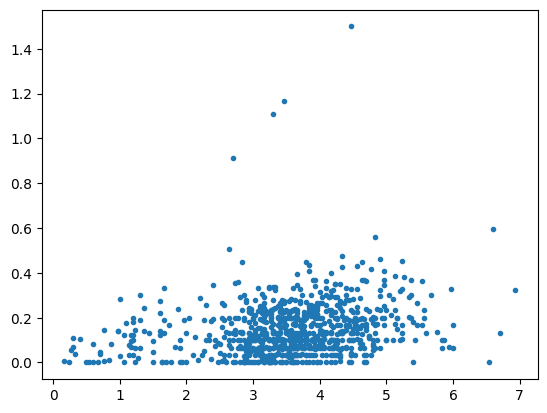

In [37]:
ind_ = df_animal_data['prev_trial_outcome']>=1


plt.plot(df_animal_data[ind_]['rt'],df_animal_data[ind_]['self_gaze_auc'],'.')


In [40]:
np.unique(df_animal_data[ind_]['failed_pulls_before_reward'])

array([0])